<a href="https://colab.research.google.com/github/Bharathi-A-7/Customer-Segmentation/blob/master/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Dataset**

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import time
%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.2f' % x)

pd.set_option('display.max_columns', None)

data = pd.read_excel('/content/drive/My Drive/Online Retail.xlsx',parse_dates=['InvoiceDate'])
data.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# **Data Preprocessing**

In [5]:
print(f'Duplicate Items in Dataset:{data.duplicated().sum()}')

Duplicate Items in Dataset:5268


# **Remove Duplicate items from dataset**

In [0]:
data = data[~data.duplicated()]

# **Check for missing values**

In [7]:
print(f'Count of Missing values:{data.isnull().sum()}')

Count of Missing values:InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64


# **Create new Invoice List**

In [8]:
#Creates a list of unique invoice No. with Null Customer ID

invoice_list = data[data.CustomerID.isnull()]['InvoiceNo'].tolist()
print(invoice_list[:10])

[536414, 536544, 536544, 536544, 536544, 536544, 536544, 536544, 536544, 536544]


In [9]:
len(data[data.InvoiceNo.isin(invoice_list)])

135037

# **Create Train Data**

# Removing Inconsistent Records

In [10]:
print("The number of records with Quantity Negative and Prices 0 or Vice versa : ",data[(data.Quantity<=0) & (data.UnitPrice<=0)].shape[0])

#Checking if Negative quantities are cancelled items 
print("Cancelled Items have Invoice Starting with : ",data.loc[(data.Quantity<0) & ~(data.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

#Checking for Records with Negative Unit Price
print("The number of transactions with Negative Unit Price : ",data[(data.UnitPrice<0)].shape[0])

#Checking for Records with Unit Price 0
print("The number of transactions with Unit Price 0 : ",data[(data.UnitPrice==0)  & ~(data.CustomerID.isnull())].shape[0])

The number of records with Quantity Negative and Prices 0 or Vice versa :  1336
Cancelled Items have Invoice Starting with :  ['C']
The number of transactions with Negative Unit Price :  2
The number of transactions with Unit Price 0 :  40


In [0]:
#Removing records with Null Customer ID
data = data[data.CustomerID.notnull()]

#Removing Transactions with Unit Price 0
data = data[data.UnitPrice>0]


In [0]:


rfm_train = data.copy()

In [0]:
rfm_train.CustomerID = (rfm_train.CustomerID).astype(int)

In [14]:
print(f'Count of Missing values:{rfm_train.isnull().sum()}')

Count of Missing values:InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


# **Cancelled Items**

In [0]:
## REMOVE transactions with Cancelled Items.

placed = rfm_train[~rfm_train.InvoiceNo.str.contains('C',na=False)]

In [16]:
placed['TotalCost'] = rfm_train.Quantity * rfm_train.UnitPrice

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# ***Exploratory Data Analysis***

In [17]:
# To Find The Time Period of Transactions

print(f'Oldest date is:{placed.InvoiceDate.min()}\n')
print(f'Latest date is:{placed.InvoiceDate.max()}\n')

Oldest date is:2010-12-01 08:26:00

Latest date is:2011-12-09 12:50:00



# **Order Density in Different Countries**

In [18]:
placed.Country.value_counts(normalize=True).head(12).mul(100).round(1).astype(str)+'%'

United Kingdom    88.9%
Germany            2.3%
France             2.1%
EIRE               1.8%
Spain              0.6%
Netherlands        0.6%
Belgium            0.5%
Switzerland        0.5%
Portugal           0.4%
Australia          0.3%
Norway             0.3%
Italy              0.2%
Name: Country, dtype: object

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


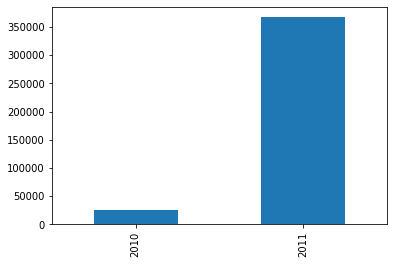

In [19]:
placed['InvoiceDate'] = pd.to_datetime(placed['InvoiceDate'], errors='coerce')
placed.InvoiceDate.dt.year.value_counts(sort=False).plot(kind='bar')


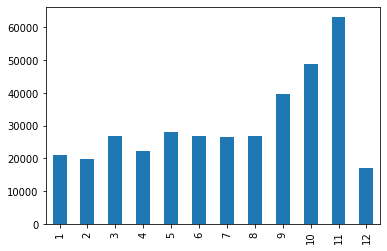

In [20]:
placed[placed.InvoiceDate.dt.year==2011].InvoiceDate.dt.month.value_counts(sort=False).plot(kind='bar')

# **Monthly Gross**

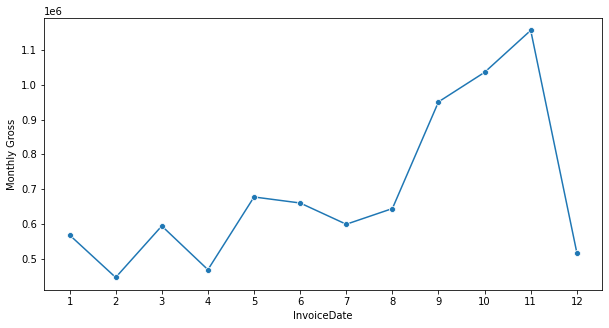

In [21]:
monthly_gross = placed[placed.InvoiceDate.dt.year==2011].groupby(placed.InvoiceDate.dt.month).TotalCost.sum()
plt.figure(figsize=(10,5))
sns.lineplot(y=monthly_gross.values,x=monthly_gross.index,marker='o')
plt.xticks(range(1,13))
plt.ylabel('Monthly Gross')
plt.show()

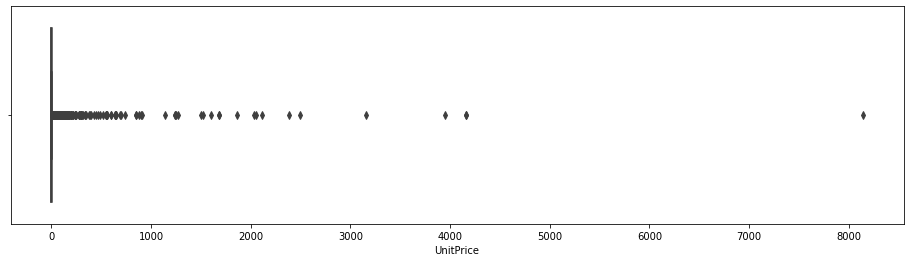

In [22]:
plt.figure(figsize=(16,4))
sns.boxplot(y='UnitPrice',data = placed,orient='h')

Unit Price is more concentrated in lower values of prices.

# **Top Selling Products**

In [23]:
placed.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalCost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


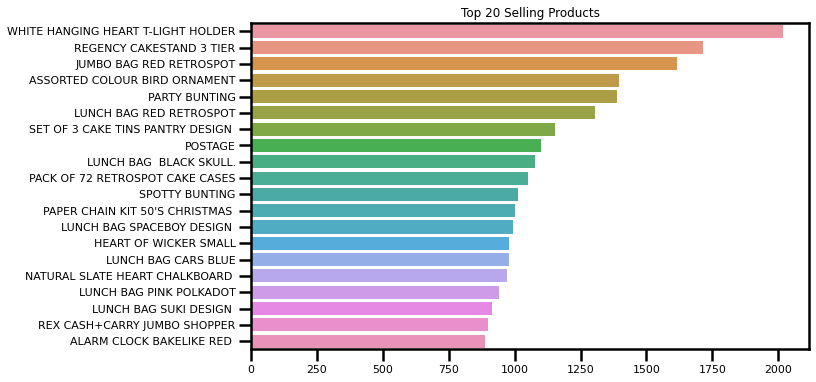

In [24]:
top_products = placed['Description'].value_counts()[:20]
plt.figure(figsize=(10,6))
sns.set_context("poster",font_scale=0.5)
sns.barplot(y=top_products.index,x=top_products.values)
plt.title('Top 20 Selling Products')
plt.show()

# **Cohort Analysis**

In [25]:
# Create a copy of rfm_train dataframe for cohort analysis
cohort = rfm_train.copy()

#cohort['InvoiceDate'] = pd.to_datetime(cohort['InvoiceDate'], errors='coerce')

# Define a function that will parse the date

#import datetime as dt

def get_month(x):
    return dt.datetime(x.year,x.month,1) 

# Create InvoiceMonth column
cohort['InvoiceMonth'] = cohort['InvoiceDate'].apply(get_month) 

# Group by CustomerID and select the InvoiceMonth value
grouping = cohort.groupby('CustomerID')['InvoiceMonth'] 
print(grouping)
# Assign a minimum InvoiceMonth value to the dataset
cohort['CohortMonth'] = grouping.transform('min')


def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month


# Get the integers for date parts from the `InvoiceMonth` column
invoice_year, invoice_month = get_date_int(cohort,'InvoiceMonth')

# Get the integers for date parts from the `CohortMonth` column
cohort_year, cohort_month = get_date_int(cohort,'CohortMonth')

# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Extract the difference in months from all previous values
cohort['CohortIndex'] = years_diff * 12 + months_diff + 1
#cohort.tail(20)


# **Retention Rate**

In [0]:
grouping = cohort.groupby(['CohortMonth','CohortIndex'])

#No. of unique values per customer ID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='CustomerID')

cohort_sizes = cohort_counts.iloc[:,0]

retention = cohort_counts.divide(cohort_sizes,axis=0)*100

#print(cohort_counts)

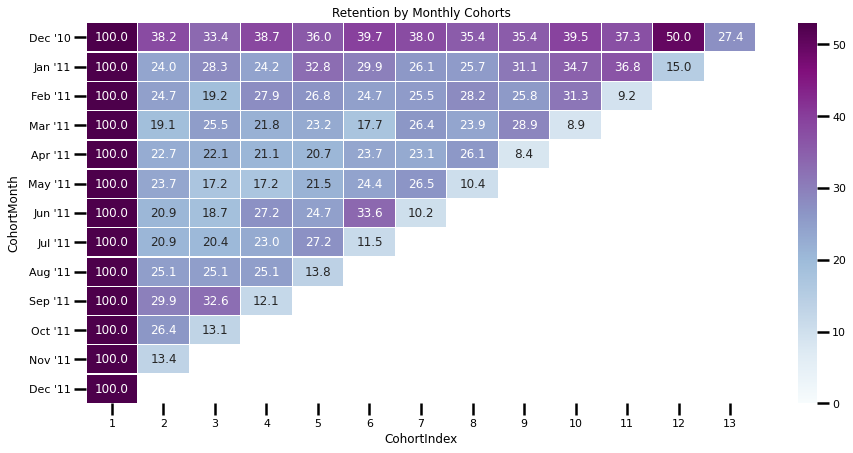

In [27]:
monthlist=["Dec '10","Jan '11","Feb '11","Mar '11","  Apr '11","May '11", "Jun '11", "Jul '11", "Aug '11", "Sep '11","Oct '11", "Nov '11", "Dec '11"]

plt.figure(figsize=(15,7))

plt.title('Retention by Monthly Cohorts')

sns.heatmap(retention,annot=True,cmap='BuPu',vmin=0.0,vmax = list(retention.max().sort_values(ascending = False))[1]+3,linewidth=0.3,fmt = '.1f',yticklabels=monthlist)

plt.show()

# **Average price per Cohort**

In [0]:
grouping = cohort.groupby(['CohortMonth','CohortIndex'])
cohort_data = grouping['UnitPrice'].mean()
cohort_data = cohort_data.reset_index()
average_price = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='UnitPrice')
average_price.round(1)
average_price.index = average_price.index.date

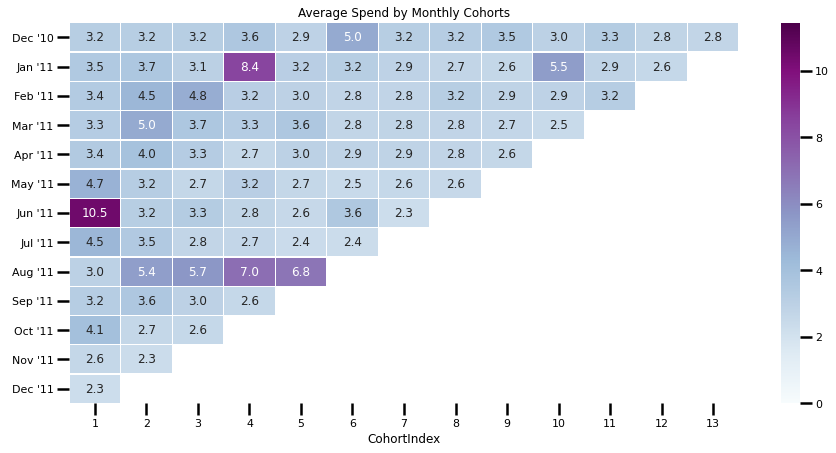

In [29]:
plt.figure(figsize=(15,7))
plt.title('Average Spend by Monthly Cohorts')
sns.heatmap(average_price,annot=True,vmin=0.0,cmap='BuPu',vmax=list(average_price.max().sort_values(ascending=False))[1]+3,fmt='.1f',linewidths=0.3,yticklabels=monthlist)
plt.show()

# **Average Quantity per Cohort**

In [0]:
grouping = cohort.groupby(['CohortMonth','CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='Quantity')


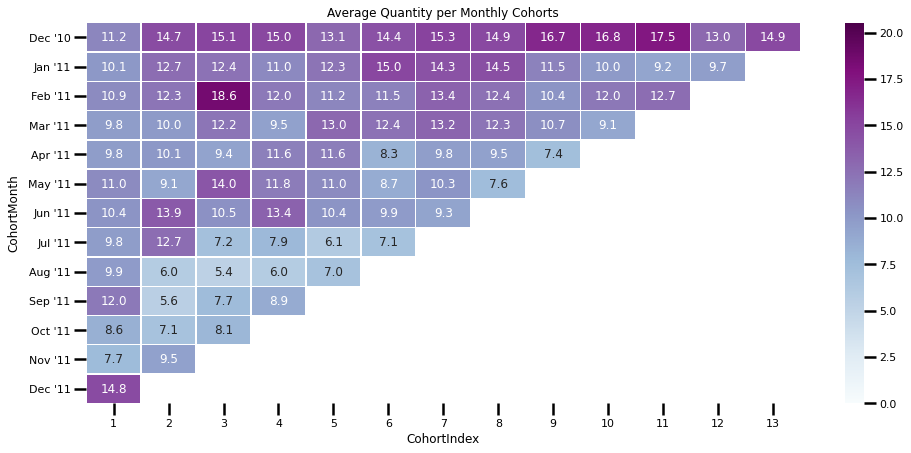

In [31]:
plt.figure(figsize=(16,7))
plt.title('Average Quantity per Monthly Cohorts')
sns.heatmap(average_quantity,vmin=0.0,vmax=list(average_quantity.max().sort_values(ascending=False))[1]+3,cmap='BuPu',linewidth=0.3,fmt='.1f',yticklabels=monthlist,annot=True)
plt.show()

# ***RFM ANALYSIS***                
![alt text](https://drive.google.com/uc?id=15SMKujEHVxb7Pi6XG_g1dOv1EFOYHtNf)

# **Recency**

In [32]:
## Lastest date in the Order History

rfm_train['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [0]:
current_date = dt.date(2011,12,10)


In [34]:
rfm_train['InvoiceDate'] = pd.to_datetime(rfm_train['InvoiceDate'], errors='coerce')

rfm_train['Purchase_Date'] = rfm_train.InvoiceDate.dt.date

print(rfm_train['Purchase_Date'])

0         2010-12-01
1         2010-12-01
2         2010-12-01
3         2010-12-01
4         2010-12-01
             ...    
541904    2011-12-09
541905    2011-12-09
541906    2011-12-09
541907    2011-12-09
541908    2011-12-09
Name: Purchase_Date, Length: 401564, dtype: object


Create Seperate Column for Recency 

In [0]:
recency = rfm_train.groupby('CustomerID')['Purchase_Date'].max().reset_index()

In [36]:
recency = recency.assign(Current_Date=current_date)
recency['Recency'] = recency.Purchase_Date.apply(lambda x:(current_date-x).days)
recency.head()

,CustomerID,Purchase_Date,Current_Date,Recency
0,12346,2011-01-18,2011-12-10,326
1,12347,2011-12-07,2011-12-10,3
2,12348,2011-09-25,2011-12-10,76
3,12349,2011-11-21,2011-12-10,19
4,12350,2011-02-02,2011-12-10,311


In [37]:
## Drop Date Columns which is not useful anymore.

recency.drop(['Purchase_Date','Current_Date'],axis=1,inplace=True)
recency.head()

,CustomerID,Recency
0,12346,326
1,12347,3
2,12348,76
3,12349,19
4,12350,311


Create Seperate Column for Frequency

In [38]:
frequency = rfm_train.groupby('CustomerID').InvoiceNo.nunique().reset_index().rename(columns={'InvoiceNo':'Frequency'})
frequency.head()

,CustomerID,Frequency
0,12346,2
1,12347,7
2,12348,4
3,12349,1
4,12350,1


Create seperate Column for Monetary

In [39]:
rfm_train['TotalCost'] = rfm_train.Quantity*rfm_train.UnitPrice
monetary = rfm_train.groupby('CustomerID').TotalCost.sum().reset_index().rename(columns={'TotalCost':'Monetary'})
monetary.head()

,CustomerID,Monetary
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


# **Combine Recency, Frequency and Monetary**

In [40]:
combine = recency.merge(frequency,on='CustomerID')
rfm_table = combine.merge(monetary,on='CustomerID')
rfm_table.set_index('CustomerID',inplace=True)
rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,2,0.00
12347,3,7,4310.00
12348,76,4,1797.24
12349,19,1,1757.55
12350,311,1,334.40


# QQ Plot

In [0]:
from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox


def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()


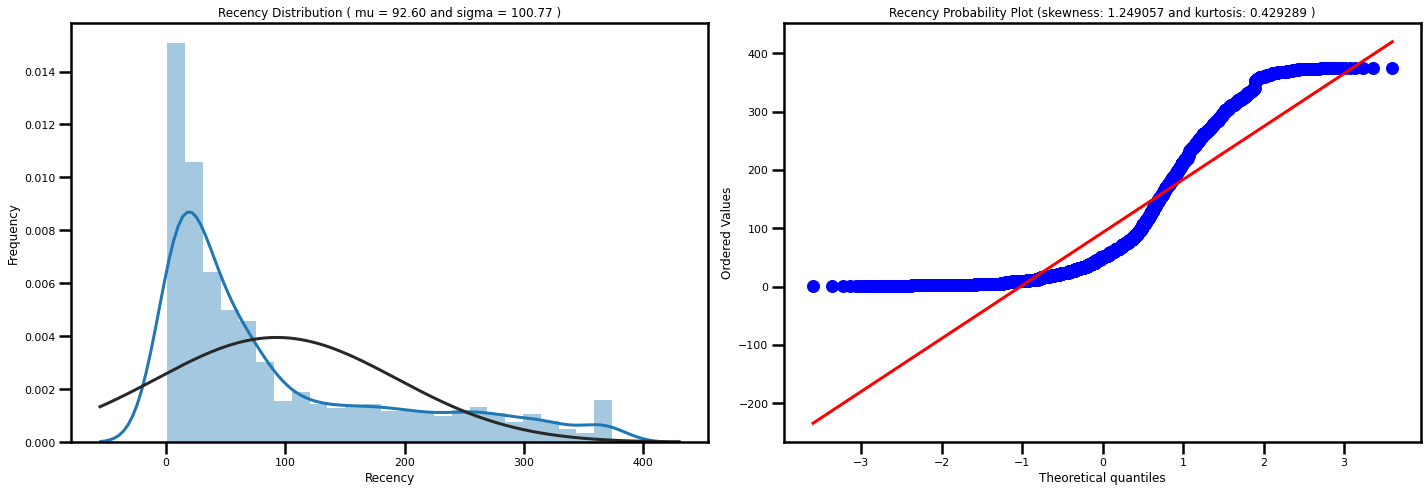

In [42]:
# Recency 
QQ_plot(rfm_table.Recency,'Recency')

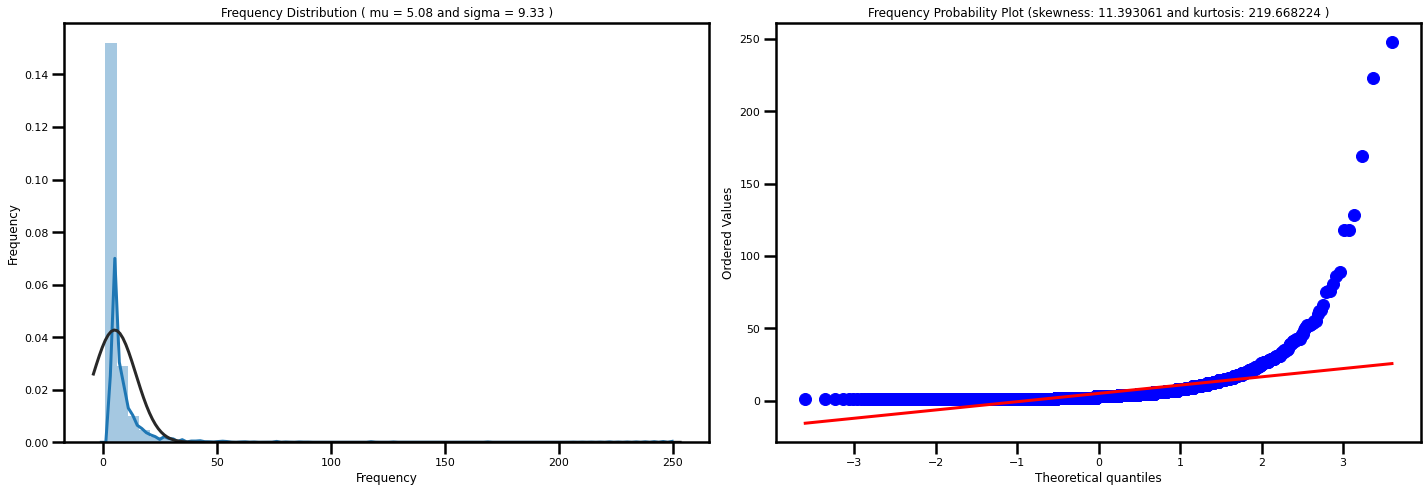

In [43]:
#Frequency 
QQ_plot(rfm_table.Frequency,'Frequency')

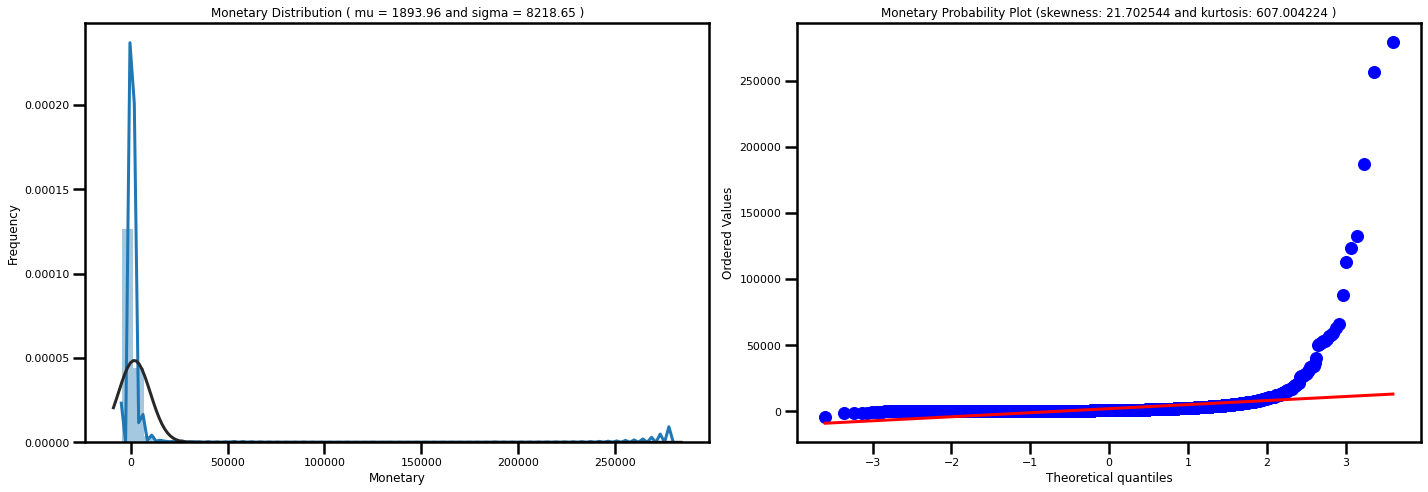

In [44]:
#Monetary 
QQ_plot(rfm_table.Monetary,'Monetary')

# **Customer Segmentation Using Quantiles**

In [45]:
quantil = rfm_table.quantile(q=[0.25,0.50,0.75])
print(quantil)

      Recency  Frequency  Monetary
0.25    17.00       1.00    291.94
0.50    51.00       3.00    644.24
0.75   144.00       5.00   1608.94


In [46]:
# Convert quantil into dict to access each value

quantil = quantil.to_dict()
print(quantil)

{'Recency': {0.25: 17.0, 0.5: 51.0, 0.75: 144.0}, 'Frequency': {0.25: 1.0, 0.5: 3.0, 0.75: 5.0}, 'Monetary': {0.25: 291.94, 0.5: 644.2400000000001, 0.75: 1608.94}}


In [47]:
def RecencyPoints(y,rfm,q):
  if y<=q[rfm][0.25]:
    return 4
  elif y<=q[rfm][0.50]:
    return 3
  elif y<=q[rfm][0.75]:
    return 2
  else:
    return 1

def Freq_MonetaryPoints(y,rfm,q):
    if y <= q[rfm][0.25]:
        return 1
    elif y <= q[rfm][0.50]:
        return 2
    elif y <= q[rfm][0.75]: 
        return 3
    else:
        return 4

rfm_segment = rfm_table.copy()
rfm_segment['Recency_Quartile'] = rfm_segment['Recency'].apply(RecencyPoints,args=('Recency',quantil,))
rfm_segment['Frequency_Quartile'] = rfm_segment['Frequency'].apply(Freq_MonetaryPoints,args=('Frequency',quantil,))
rfm_segment['Monetary_Quartile'] = rfm_segment['Monetary'].apply(Freq_MonetaryPoints,args=('Monetary',quantil,))
rfm_segment.head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile
CustomerID,,,,,,
12346,326,2,0.00,1,2,1
12347,3,7,4310.00,4,4,4
12348,76,4,1797.24,2,3,4
12349,19,1,1757.55,3,1,4
12350,311,1,334.40,1,1,2


In [48]:
rfm_segment['RFMPoints'] = rfm_segment.Recency_Quartile.map(str)+rfm_segment.Frequency_Quartile.map(str)+rfm_segment.Monetary_Quartile.map(str)
print(rfm_segment['RFMPoints'])

CustomerID
12346    121
12347    444
12348    234
12349    314
12350    112
        ... 
18280    111
18281    111
18282    421
18283    444
18287    324
Name: RFMPoints, Length: 4371, dtype: object


# **RFM Classification**

In [0]:
customer_dict = {'Best Customers':'444','Loyal Customers':'344','Big Spender':'334','Almost Lost':'244','Lost Customers':'144','Recent Customers':'443','Lost Cheap Customers':'122'}


In [50]:
dict_segment = dict(zip( customer_dict.values(),customer_dict.keys()))

rfm_segment['Segment'] = rfm_segment.RFMPoints.map(lambda x:dict_segment.get(x))
rfm_segment.Segment.fillna('others',inplace = True)
rfm_segment.sample(10)

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment
CustomerID,,,,,,,,
12356,23,3,2811.43,3,2,4,324,others
12886,68,3,1351.09,2,2,3,223,others
13875,54,5,1786.79,2,3,4,234,others
15100,331,6,635.10,1,4,2,142,others
16808,100,2,288.42,2,2,1,221,others
16187,32,17,6841.24,3,4,4,344,Loyal Customers
16411,20,2,211.70,3,2,1,321,others
12910,24,8,3075.04,3,4,4,344,Loyal Customers
13473,61,3,417.54,2,2,2,222,others


In [51]:
# Best Customers who's recency, frequency as well as monetary attribute is highest.
rfm_segment[rfm_segment.RFMPoints=='444'].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment
CustomerID,,,,,,,,
14646,2,76,279489.02,4,4,4,444,Best Customers
18102,1,62,256438.49,4,4,4,444,Best Customers
17450,9,55,187322.17,4,4,4,444,Best Customers
14911,2,248,132458.73,4,4,4,444,Best Customers
14156,10,66,113214.59,4,4,4,444,Best Customers


In [52]:
# Big Spenders 
rfm_segment[rfm_segment.RFMPoints=='334'].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment
CustomerID,,,,,,,,
16126,30,4,6287.77,3,3,4,334,Big Spender
13316,38,5,5570.69,3,3,4,334,Big Spender
16303,26,4,5305.83,3,3,4,334,Big Spender
16258,46,5,5203.51,3,3,4,334,Big Spender
12432,43,5,5059.32,3,3,4,334,Big Spender


In [53]:
# Almost Lost who's recency is very low
rfm_segment[rfm_segment.RFMPoints=='244'].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment
CustomerID,,,,,,,,
12939,65,8,11581.80,2,4,4,244,Almost Lost
12409,79,7,11056.93,2,4,4,244,Almost Lost
16180,101,10,10217.48,2,4,4,244,Almost Lost
12744,52,10,9120.39,2,4,4,244,Almost Lost
16745,87,18,7157.10,2,4,4,244,Almost Lost


In [54]:
 #Lost customers that don't need attention who's recency, frequency as well as monetary values are low
rfm_segment[rfm_segment.RFMPoints=='122'].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment
CustomerID,,,,,,,,
14481,165,2,636.51,1,2,2,122,Lost Cheap Customers
15384,170,3,635.76,1,2,2,122,Lost Cheap Customers
14000,207,2,633.71,1,2,2,122,Lost Cheap Customers
15045,152,3,633.66,1,2,2,122,Lost Cheap Customers
14220,248,2,632.40,1,2,2,122,Lost Cheap Customers


In [55]:
# loyal customers who's purchase frequency is high
rfm_segment[rfm_segment.RFMPoints=='344'].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment
CustomerID,,,,,,,,
12415,25,26,123725.45,3,4,4,344,Loyal Customers
16029,39,76,53168.69,3,4,4,344,Loyal Customers
16422,18,75,33805.69,3,4,4,344,Loyal Customers
12931,22,20,33462.81,3,4,4,344,Loyal Customers
14680,26,23,26932.34,3,4,4,344,Loyal Customers


In [56]:
#customers that you must retain are those whose monetary and frequency was high but recency reduced quite a lot recently
rfm_segment[rfm_segment.RFMPoints=='244'].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment
CustomerID,,,,,,,,
12939,65,8,11581.80,2,4,4,244,Almost Lost
12409,79,7,11056.93,2,4,4,244,Almost Lost
16180,101,10,10217.48,2,4,4,244,Almost Lost
12744,52,10,9120.39,2,4,4,244,Almost Lost
16745,87,18,7157.10,2,4,4,244,Almost Lost


# **K-Means Clustering**

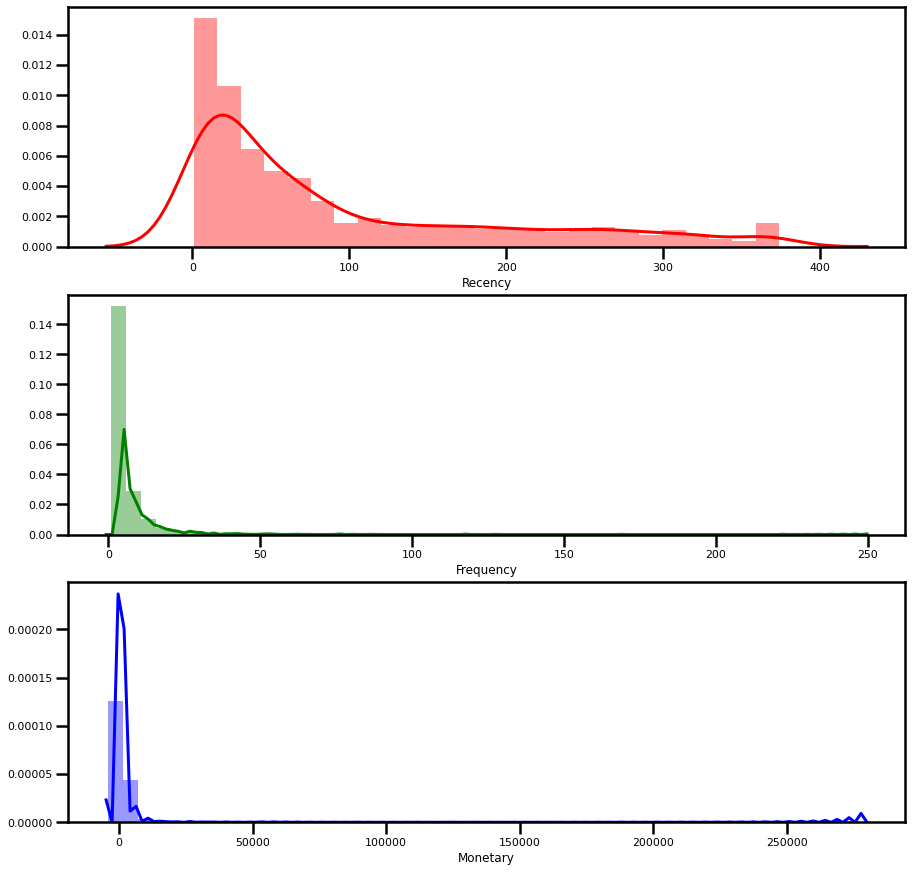

In [57]:
fig,axes = plt.subplots(3,1,figsize=(15,15))
sns.distplot(rfm_table.Recency,color='Red',axlabel='Recency',ax=axes[0])
sns.distplot(rfm_table.Frequency,color='Green',axlabel='Frequency',ax=axes[1])
sns.distplot(rfm_table.Monetary,color='Blue',axlabel='Monetary',ax=axes[2])
plt.show()

In [58]:
rfm_table.describe()

,Recency,Frequency,Monetary
count,4371.00,4371.00,4371.00
mean,92.60,5.08,1893.96
std,100.78,9.33,8219.59
min,1.00,1.00,-4287.63
25%,17.00,1.00,291.94
50%,51.00,3.00,644.24
75%,144.00,5.00,1608.94
max,374.00,248.00,279489.02


In [59]:
scaled_rfm = rfm_table.copy()
scaled_rfm.Monetary = rfm_table.Monetary + abs(rfm_table.Monetary.min())+1
scaled_rfm.Recency = rfm_table.Recency + abs(rfm_table.Recency.min())+1
scaled_rfm.describe()

,Recency,Frequency,Monetary
count,4371.00,4371.00,4371.00
mean,94.60,5.08,6182.59
std,100.78,9.33,8219.59
min,3.00,1.00,1.00
25%,19.00,1.00,4580.57
50%,53.00,3.00,4932.87
75%,146.00,5.00,5897.57
max,376.00,248.00,283777.65


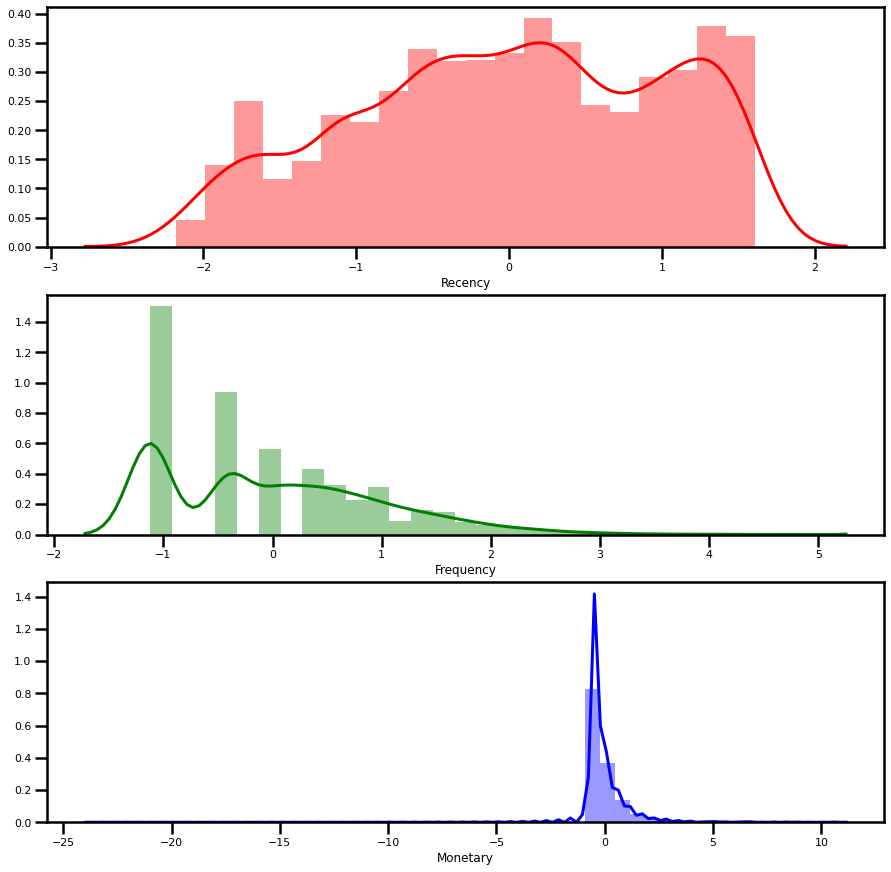

In [60]:
import numpy as np

from sklearn.preprocessing import StandardScaler

log_df = np.log(scaled_rfm)
scal = StandardScaler()
normal_ = scal.fit_transform(log_df)
normal_ = pd.DataFrame(data=normal_,index = rfm_table.index,columns=rfm_table.columns)

fig, axes = plt.subplots(3, 1, figsize=(15, 15))
sns.distplot(normal_.Recency , color="Red", ax=axes[0], axlabel='Recency')
sns.distplot(normal_.Frequency , color="Green", ax=axes[1], axlabel='Frequency')
sns.distplot(normal_.Monetary , color="Blue", ax=axes[2], axlabel='Monetary')
plt.show()

# **Silhouette Method for Finding Optimal K-value**

Silhouette score for number of cluster(s) 2: 0.4351127490179922
Silhouette score for number of cluster(s) 3: 0.39384837911172893
Silhouette score for number of cluster(s) 4: 0.3427676527010397
Silhouette score for number of cluster(s) 5: 0.36148198945999327
Silhouette score for number of cluster(s) 6: 0.35890330314451613
Silhouette score for number of cluster(s) 7: 0.36069448367673096
Silhouette score for number of cluster(s) 8: 0.34870809815400866
Silhouette score for number of cluster(s) 9: 0.34681726993069817
Silhouette score for number of cluster(s) 10: 0.363540853971974
Silhouette score for number of cluster(s) 11: 0.3621429706041307


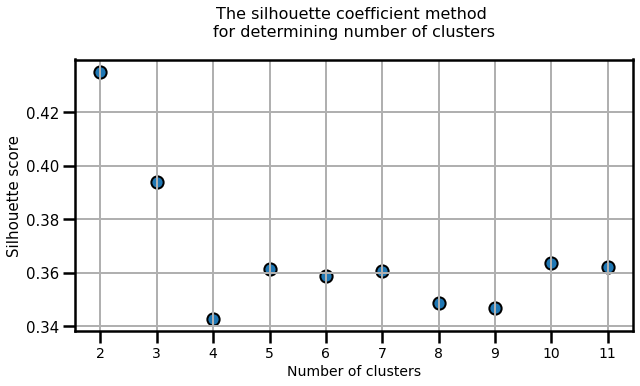

In [61]:
 from sklearn.metrics import silhouette_score
 from sklearn.cluster import KMeans
wcss_silhouette = []
for i in range(2,12):
    kmean = KMeans(n_clusters=i, random_state=0,init='k-means++').fit(normal_)
    predss = kmean.predict(normal_)    
    silhouette = silhouette_score(normal_,predss)
    wcss_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))

plt.figure(figsize=(10,5))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=wcss_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

# **Optimal Value for K is 4**

In [62]:
kme = KMeans(n_clusters=4, random_state=1, init='k-means++')
kme.fit(normal_)
cluster_labels = kme.labels_
print(f"Shape of cluster label array is {cluster_labels.shape}")
print(f"Shape of RFM segment dataframe is {rfm_segment.shape}")
Cluster_table = rfm_segment.assign(Cluster = cluster_labels)

# Check counts of records assigned to different clusters
Cluster_table.Cluster.value_counts()

Shape of cluster label array is (4371,)
Shape of RFM segment dataframe is (4371, 8)


2    1805
0    1217
3    1173
1     176
Name: Cluster, dtype: int64

In [63]:
Cluster_table.sample(10)

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment,Cluster
CustomerID,,,,,,,,,
15095,104,5,1364.70,2,3,3,233,others,2
14679,372,1,-2.55,1,1,1,111,others,2
12441,367,1,173.55,1,1,1,111,others,2
18249,18,1,95.34,3,1,1,311,others,0
16215,81,1,242.35,2,1,1,211,others,2
17102,262,1,25.50,1,1,1,111,others,2
18172,15,25,7490.17,4,4,4,444,Best Customers,1
16518,62,3,480.92,2,2,2,222,others,0
15990,45,2,792.11,3,2,3,323,others,0


In [64]:
Cluster_table[Cluster_table.Cluster == 3].sample(5)

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment,Cluster
CustomerID,,,,,,,,,
18171,59,7,1208.51,2,4,3,243,others,3
12955,2,14,4734.26,4,4,4,444,Best Customers,3
12839,3,16,5583.62,4,4,4,444,Best Customers,3
14233,44,5,1447.51,3,3,3,333,others,3
14132,3,12,3580.13,4,4,4,444,Best Customers,3


In [65]:
Cluster_table[Cluster_table.Cluster == 2].sample(5)

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment,Cluster
CustomerID,,,,,,,,,
13963,309,4,664.54,1,3,3,133,others,2
15325,104,1,161.74,2,1,1,211,others,2
18037,155,6,70.02,1,4,1,141,others,2
17433,89,1,303.16,2,1,2,212,others,2
18119,368,1,180.70,1,1,1,111,others,2


In [66]:
Cluster_table[Cluster_table.Cluster == 1].sample(5)

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment,Cluster
CustomerID,,,,,,,,,
15290,5,21,7803.77,4,4,4,444,Best Customers,1
12476,2,20,6546.58,4,4,4,444,Best Customers,1
15023,4,12,6680.81,4,4,4,444,Best Customers,1
13969,8,20,8956.92,4,4,4,444,Best Customers,1
15769,8,29,51823.72,4,4,4,444,Best Customers,1


In [67]:
Cluster_table[Cluster_table.Cluster == 0].sample(5)

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment,Cluster
CustomerID,,,,,,,,,
17458,16,1,316.50,4,1,2,412,others,0
13669,51,2,218.55,3,2,1,321,others,0
13292,39,2,578.94,3,2,2,322,others,0
16464,20,3,1298.66,3,2,3,323,others,0
14959,60,5,684.97,2,3,3,233,others,0


# **Clusters in Scatter Plot**

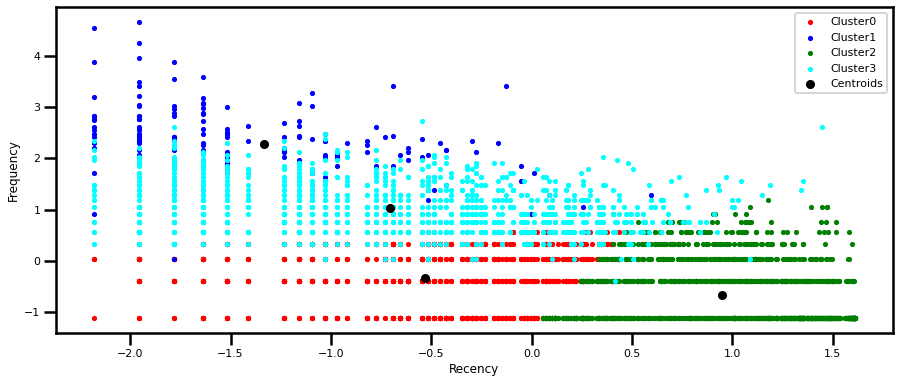

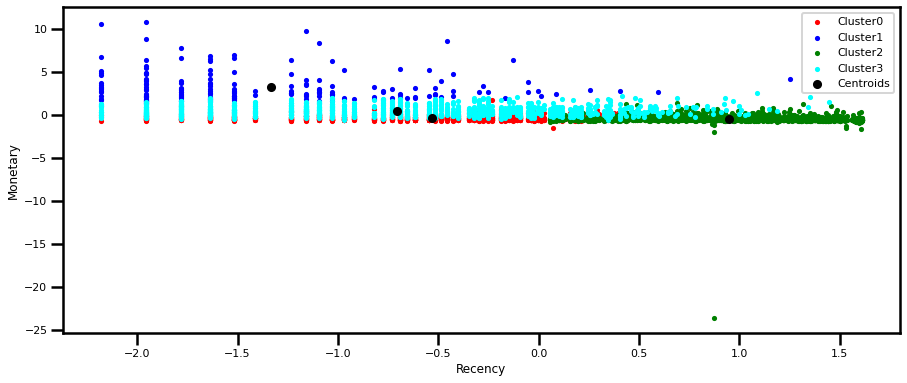

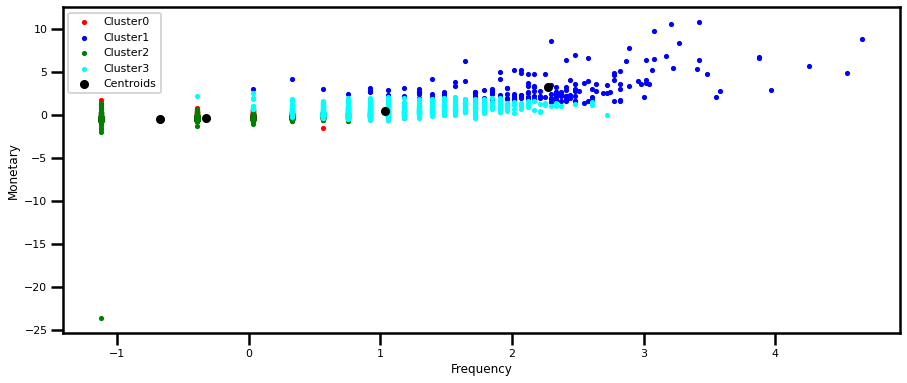

In [68]:
# Plotting two dimesional plots of each attributes respectively.
Y = normal_.iloc[:,0:3].values
count=Y.shape[1]
for i in range(0,count):
    for j in range(i+1,count):
        plt.figure(figsize=(15,6));
        plt.scatter(Y[cluster_labels == 0, i], Y[cluster_labels == 0, j], s = 10, c = 'red', label = 'Cluster0')
        plt.scatter(Y[cluster_labels == 1, i], Y[cluster_labels == 1, j], s = 10, c = 'blue', label = 'Cluster1')
        plt.scatter(Y[cluster_labels == 2, i], Y[cluster_labels == 2, j], s = 10, c = 'green', label = 'Cluster2')
        plt.scatter(Y[cluster_labels == 3, i], Y[cluster_labels == 3, j], s = 10, c = 'cyan', label = 'Cluster3')
        plt.scatter(kme.cluster_centers_[:,i], kme.cluster_centers_[:,j], s = 50, c = 'black', label = 'Centroids')
        plt.xlabel(normal_.columns[i])
        plt.ylabel(normal_.columns[j])
        plt.legend()        
        plt.show();

# **Snake Plot**

# Melt in Pandas

In [69]:
# Assign Cluster values to each customer in normalized dataframe
normal_ = normal_.assign(Cluster = cluster_labels)

# Melt normalized dataframe into long form to have all metric in same column
normal_melt = pd.melt(normal_.reset_index(),
                      id_vars=['CustomerID','Cluster'],
                      value_vars=['Recency', 'Frequency', 'Monetary'],
                      var_name='Metric',
                      value_name='Value')
normal_melt.head()

,CustomerID,Cluster,Metric,Value
0,12346,2,Recency,1.50
1,12347,3,Recency,-1.78
2,12348,0,Recency,0.38
3,12349,0,Recency,-0.65
4,12350,2,Recency,1.47


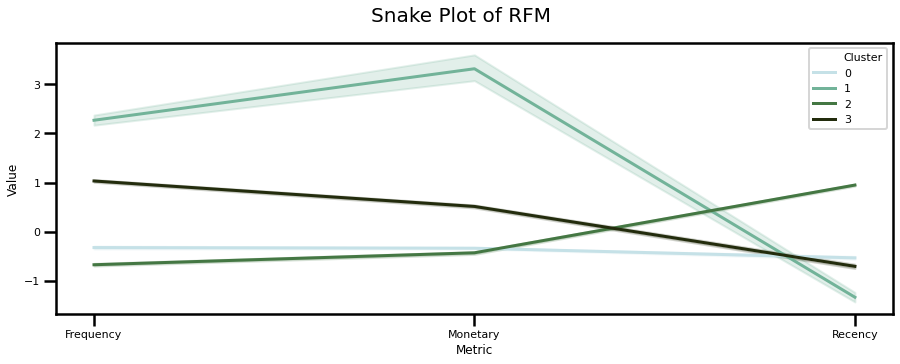

In [70]:
plt.figure(figsize=(15,5))
palette = sns.color_palette("mako_r", 4)
sns.lineplot(x = 'Metric',y = 'Value',hue = 'Cluster',data = normal_melt,palette = "ch:4.4,.44")
plt.suptitle("Snake Plot of RFM",fontsize=20)
plt.show()

## **Association Mining**

# Create Transaction Level Dataframe

In [0]:
items = list(rfm_train.Description.unique())
grouped = rfm_train.groupby('InvoiceNo')
transaction_level = grouped.aggregate(lambda x: tuple(x)).reset_index()[['InvoiceNo','Description']]
# A Transaction dataframe with items as columns with binary values is created
transaction_dict = {item:0 for item in items}
output_dict = dict()
temp = dict()
for rec in transaction_level.to_dict('records'):
    invoice_num = rec['InvoiceNo']
    items_list = rec['Description']
    transaction_dict = {item:0 for item in items}
    transaction_dict.update({item:1 for item in items if item in items_list})
    temp.update({invoice_num:transaction_dict})

new = [v for k,v in temp.items()]
transaction_df = pd.DataFrame(new)



# Pruning the Dataset for frequently purchased items

In [0]:
def prune_dataset(input_df, length_trans = 2, total_sales_perc = 0.5, 
                  start_item = None, end_item = None, TopCols = None):
    if 'total_items' in input_df.columns:
        del(input_df['total_items'])
    item_count = input_df.sum().sort_values(ascending = False).reset_index()
    
    total_items = sum(input_df.sum().sort_values(ascending = False))
    #print(total_items)
    item_count.rename(columns={item_count.columns[0]:'item_name',
                               item_count.columns[1]:'item_count'}, inplace=True)
    if TopCols: 
        input_df['total_items'] = input_df[TopCols].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[TopCols], item_count[item_count.item_name.isin(TopCols)]
    elif end_item > start_item:
        selected_items = list(item_count[start_item:end_item].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items],item_count[start_item:end_item]
    else:
        item_count['item_perc'] = item_count['item_count']/total_items
        item_count['total_perc'] = item_count.item_perc.cumsum()
        selected_items = list(item_count[item_count.total_perc < total_sales_perc].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items], item_count[item_count.total_perc < total_sales_perc]



Adding an additional column denoting the total amount in a purchase

In [0]:
rfm_train['Amount'] = rfm_train.Quantity*rfm_train.UnitPrice

In [0]:
AmoutSum = rfm_train.groupby(["Description"]).Amount.sum().sort_values(ascending = False)
inv = rfm_train[["Description", "InvoiceNo"]].groupby(["Description"]).InvoiceNo.unique().\
 agg(np.size).sort_values(ascending = False)
Top10Ev = list(inv[:10].index)
Top15ev = list(inv[:15].index)


Pruning based on Rank of items

In [75]:
output_df, item_counts = prune_dataset(input_df=transaction_df, length_trans=2,start_item = 0, end_item = 15)
print(output_df)
print('Total of Sales Amount by the Top 15 Products in Sales Events (Invoice): {:.2f}'.format(AmoutSum[Top15ev].sum()))
print('Number of Sales Events:', output_df.shape[0])
print('Number of Products:', output_df.shape[1])



       WHITE HANGING HEART T-LIGHT HOLDER  REGENCY CAKESTAND 3 TIER  \
13                                      0                         0   
23                                      1                         0   
27                                      0                         0   
33                                      1                         0   
36                                      0                         0   
...                                   ...                       ...   
21809                                   1                         0   
21938                                   0                         1   
21983                                   0                         0   
21995                                   0                         1   
22069                                   0                         0   

       JUMBO BAG RED RETROSPOT  PARTY BUNTING  ASSORTED COLOUR BIRD ORNAMENT  \
13                           0              0                      

# Importing Necessary Libraries for Association Rule Mining

In [76]:
!pip install orange3

     |████████████████████████████████| 2.6MB 6.4MB/s 
     |████████████████████████████████| 1.8MB 39.4MB/s 
     |████████████████████████████████| 1.6MB 37.3MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
     |████████████████████████████████| 143kB 41.3MB/s 
     |████████████████████████████████| 450kB 44.1MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 225kB 44.2MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 890kB 37.3MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 2.7MB 43.4MB/s 
     |████████████████████████████████| 102kB 11.0MB/s 
  Created wheel for pyqtgraph: filename=pyqtgraph-0.10.0-cp36-none-any.whl size=735678 sha256=29e11483e1b76646ca03279170087f8c5471a0f313dae53df73e29ea1add8d6d
  Stored in directory: /root/.cache/pip/wheels/93/a2/de/184ecdefdb91

In [77]:
!pip3 install Orange3-Associate

     |████████████████████████████████| 532kB 6.4MB/s 
  Created wheel for Orange3-Associate: filename=Orange3_Associate-1.1.5-cp36-cp36m-linux_x86_64.whl size=186222 sha256=c9facd032366fb56810024e2da095984f7108b3f7e6abfbba5a7284fbaf66fc4
  Stored in directory: /root/.cache/pip/wheels/80/61/4a/dcd517a56d437ea374e32f2c7ffdb31047edab82d82d665af5
Successfully built Orange3-Associate


In [0]:
import Orange
from Orange.data import Domain, DiscreteVariable, ContinuousVariable
from sklearn import preprocessing
from orangecontrib.associate.fpgrowth import *


# Creating Orange Table Data Structure

In [79]:
input_assoc_rules = output_df
# Defined the data domain by specifying each variable as a DiscreteVariable having values as (0, 1)
domain_transac = Domain([DiscreteVariable.make(name=item,values=['0', '1']) \
                         for item in input_assoc_rules.columns])


# Then using this domain, we created our Table structure for our data
data_tran = Orange.data.Table.from_numpy(domain=domain_transac,  
                                         X=input_assoc_rules.values,Y= None)


# Coding our input so that the entire domain is represented as binary variables
data_tran_en, mapping = OneHot.encode(data_tran, include_class=True)
print(data_tran_en)
print(sorted(mapping.items()))

[[ True False  True ... False  True False]
 [False  True  True ... False  True False]
 [ True False  True ... False  True False]
 ...
 [ True False  True ... False  True False]
 [ True False False ... False  True False]
 [ True False  True ... False  True False]]
[(0, (0, 0)), (1, (0, 1)), (2, (1, 0)), (3, (1, 1)), (4, (2, 0)), (5, (2, 1)), (6, (3, 0)), (7, (3, 1)), (8, (4, 0)), (9, (4, 1)), (10, (5, 0)), (11, (5, 1)), (12, (6, 0)), (13, (6, 1)), (14, (7, 0)), (15, (7, 1)), (16, (8, 0)), (17, (8, 1)), (18, (9, 0)), (19, (9, 1)), (20, (10, 0)), (21, (10, 1)), (22, (11, 0)), (23, (11, 1)), (24, (12, 0)), (25, (12, 1)), (26, (13, 0)), (27, (13, 1)), (28, (14, 0)), (29, (14, 1))]


/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [80]:
support = 0.01
# Number of minimum transactions for each rule
print("Number  of required transactions = ", int(input_assoc_rules.shape[0]*support))
num_trans = input_assoc_rules.shape[0]*support
itemsets = dict(frequent_itemsets(data_tran_en, support))
print('Items Set Size:', len(itemsets))

Number  of required transactions =  47
Items Set Size: 661418


### **Generating Rules using FP Growth Algorithm**

In [81]:
confidence = 0.6
rules_df = pd.DataFrame()
if len(itemsets) < 1000000: 
    rules = [(P, Q, supp, conf)
    for P, Q, supp, conf in association_rules(itemsets, confidence)
       if len(Q) == 1 ]

    names = {item: '{}={}'.format(var.name, val)
        for item, var, val in OneHot.decode(mapping, data_tran, mapping)}
    print(names)
    
    eligible_ante = [v for k,v in names.items() if v.endswith("1")]
    
    N = input_assoc_rules.shape[0]
    
    rule_stats = list(rules_stats(rules, itemsets, N))
    
    rule_list_df = []
    for ex_rule_frm_rule_stat in rule_stats:
        ante = ex_rule_frm_rule_stat[0]     
        cons = ex_rule_frm_rule_stat[1]

        named_cons = names[next(iter(cons))]
       
        if named_cons in eligible_ante:
            rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
            ante_rule = ', '.join(rule_lhs)
            if ante_rule and len(rule_lhs)>1 :
                rule_dict = {'support' : ex_rule_frm_rule_stat[2],
                             'confidence' : ex_rule_frm_rule_stat[3],
                             'coverage' : ex_rule_frm_rule_stat[4],
                             'strength' : ex_rule_frm_rule_stat[5],
                             'lift' : ex_rule_frm_rule_stat[6],
                             'leverage' : ex_rule_frm_rule_stat[7],
                             'antecedent': ante_rule,
                             'consequent':named_cons[:-2] }
                rule_list_df.append(rule_dict)
   
    rules_df = pd.DataFrame(rule_list_df)
    print("Raw rules data frame of {} rules generated".format(rules_df.shape[0]))
    if  rules_df.empty:
        print("No rule generated")
    pd.options.display.max_colwidth = 10  
    print(rules_df.head())

{0: 'WHITE HANGING HEART T-LIGHT HOLDER=0', 1: 'WHITE HANGING HEART T-LIGHT HOLDER=1', 2: 'REGENCY CAKESTAND 3 TIER=0', 3: 'REGENCY CAKESTAND 3 TIER=1', 4: 'JUMBO BAG RED RETROSPOT=0', 5: 'JUMBO BAG RED RETROSPOT=1', 6: 'PARTY BUNTING=0', 7: 'PARTY BUNTING=1', 8: 'ASSORTED COLOUR BIRD ORNAMENT=0', 9: 'ASSORTED COLOUR BIRD ORNAMENT=1', 10: 'LUNCH BAG RED RETROSPOT=0', 11: 'LUNCH BAG RED RETROSPOT=1', 12: 'SET OF 3 CAKE TINS PANTRY DESIGN =0', 13: 'SET OF 3 CAKE TINS PANTRY DESIGN =1', 14: 'POSTAGE=0', 15: 'POSTAGE=1', 16: 'LUNCH BAG  BLACK SKULL.=0', 17: 'LUNCH BAG  BLACK SKULL.=1', 18: 'PACK OF 72 RETROSPOT CAKE CASES=0', 19: 'PACK OF 72 RETROSPOT CAKE CASES=1', 20: 'SPOTTY BUNTING=0', 21: 'SPOTTY BUNTING=1', 22: 'LUNCH BAG SPACEBOY DESIGN =0', 23: 'LUNCH BAG SPACEBOY DESIGN =1', 24: "PAPER CHAIN KIT 50'S CHRISTMAS =0", 25: "PAPER CHAIN KIT 50'S CHRISTMAS =1", 26: 'LUNCH BAG CARS BLUE=0', 27: 'LUNCH BAG CARS BLUE=1', 28: 'NATURAL SLATE HEART CHALKBOARD =0', 29: 'NATURAL SLATE HEART CHA

# First 5 rules with Highest Confidence

In [82]:
#Storing the value of default column width in a temporary variable default_width
default_width = pd.options.display.max_colwidth

pd.options.display.max_colwidth = 50


print((rules_df[['consequent','antecedent', 'support','confidence','lift']].
 sort_values(['confidence','support','lift'],ascending=False)))


                    consequent  \
2210   LUNCH BAG RED RETROSPOT   
4621   LUNCH BAG RED RETROSPOT   
4943   LUNCH BAG RED RETROSPOT   
4659   LUNCH BAG RED RETROSPOT   
7632   LUNCH BAG RED RETROSPOT   
...                        ...   
12658  LUNCH BAG RED RETROSPOT   
12685  LUNCH BAG RED RETROSPOT   
13113  LUNCH BAG RED RETROSPOT   
13175  LUNCH BAG RED RETROSPOT   
13246  LUNCH BAG RED RETROSPOT   

                                              antecedent  support  confidence  \
2210   JUMBO BAG RED RETROSPOT, LUNCH BAG  BLACK SKUL...       54        0.82   
4621   JUMBO BAG RED RETROSPOT, LUNCH BAG  BLACK SKUL...       54        0.82   
4943   JUMBO BAG RED RETROSPOT, LUNCH BAG  BLACK SKUL...       57        0.81   
4659   JUMBO BAG RED RETROSPOT, LUNCH BAG  BLACK SKUL...       61        0.81   
7632   JUMBO BAG RED RETROSPOT, LUNCH BAG  BLACK SKUL...       61        0.81   
...                                                  ...      ...         ...   
12658  JUMBO BAG RED RET

# First 5 rules with Highest Support

In [83]:
pd.options.display.max_colwidth = 10

print((rules_df[['consequent', 'antecedent', 'support','confidence','lift']].
 groupby(['consequent', 'antecedent']).first().reset_index().sort_values(['support', 'confidence', 'lift'],ascending=False)).head())

   consequent antecedent  support  confidence  lift
36  LUNCH ...  LUNCH ...      200       0.61   2.41
37  LUNCH ...  LUNCH ...      198       0.60   2.38
39  LUNCH ...  LUNCH ...      153       0.60   2.39
25  LUNCH ...  LUNCH ...      137       0.66   2.62
31  LUNCH ...  LUNCH ...      134       0.61   2.40


Checking for rules with lift > 1

In [84]:
print(rules_df.lift.apply(lambda x: 'Greater Than One' if x > 1 else 'One' \
                           if x == 0 else 'Less Than One').value_counts())

Greater Than One    13275
Name: lift, dtype: int64


Setting maximum column width to the initial default value 

In [0]:
pd.options.display.max_colwidth = default_width

## **Recommendation**

In [0]:
print(" Please choose an Item : ")
print(" Available Items :" ) 
available_items = rules_df['consequent'].unique()
available_items = pd.DataFrame(available_items)
print(available_items)
chosen_item = input()
recommend_items_df = rules_df.loc[rules_df['consequent']==chosen_item]['antecedent']

print(" Products related to your chosen item . Consider purchasing the following products : ")
print(recommend_items_df.head(10).unique())

 Please choose an Item : 
 Available Items :
           0
0  LUNCH ...
1  LUNCH ...
2  LUNCH ...
3  LUNCH ...
